# Previsão de Engajamento - Classificação

Este notebook define modelos e hiperparâmetros e executa um validação cruzada aninhada com grid search para otimização de hiperparâmetros e treinamento.

- Entrada: `full-preproc2-inputs` e `full-preproc2-outputs`
- Saída: `resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}.npy`


In [1]:
#@title Importações de pacote
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
BASE_PATH = 'dados/'

# 1 - Carregando os Dados

Carregando dados brutos gerais.

In [3]:
dfx = pd.read_excel(BASE_PATH + 'full-preproc2-inputs.xlsx', index_col='ID')
dfx.head()

,Candidato_Bolsonaro,Candidato_Lula,Dispositivo Retórico,Main character,Retórica Aristotélica,Tipo de conteúdo,Texto / Hashtag,Tonalidade,Abordagem,Duracao,DiasDecorridos
ID,,,,,,,,,,,
7114971700365691904,1,0,Political Statement,Self alone,Pathos,Campaign Act,Hashtag,Neutral,Acclamation,57.93,94
7115050482179050496,1,0,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Positive,Acclamation,17.13,94
7115120078982630400,1,0,Commitment,Self + voters,Ethos,Political-Purposeful,Hashtag,Positive,Acclamation,52.54,94
7115161088219565056,1,0,Humor,Self alone,Nenhum,Personal,Hashtag,Positive,Acclamation,34.48,94
7115207919750253568,1,0,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Negative,Attack,66.66,94


In [4]:
dfy_full = pd.read_excel(BASE_PATH + 'full-preproc2-outputs.xlsx', index_col='ID')
dfy_full.head()

,Curtidas,Curtidas-Log,Curtidas-MinMax,Curtidas-Log-MinMax,Curtidas-2Classes-75p,Curtidas-2Classes-50p
ID,,,,,,
7114971700365691904,24400,4.387390,0.018396,0.374522,0,0
7115050482179050496,9163,3.962038,0.005674,0.217264,0,0
7115120078982630400,3485,3.542203,0.000933,0.062046,0,0
7115161088219565056,22100,4.344392,0.016476,0.358626,0,0
7115207919750253568,115700,5.063333,0.094630,0.624428,1,1


## 1.1 - Escolha do Dataset (ALTERE)

In [5]:
from util import filter_dataset

# 'geral', 'lula' ou 'bolsonaro'
SUB_DATASET = 'bolsonaro'

TARGET_COL = 'Curtidas-2Classes-50p'

In [6]:
dfx, dfy = filter_dataset(dfx, dfy_full, SUB_DATASET, TARGET_COL)

Dataset BOLSONARO (indicador 0)


In [ ]:
#dfx.columns
dfx.shape

Index(['Dispositivo Retórico', 'Main character', 'Retórica Aristotélica',
       'Tipo de conteúdo', 'Texto / Hashtag', 'Tonalidade', 'Abordagem',
       'Duracao', 'DiasDecorridos'],
      dtype='object')

In [ ]:
#dfy.head()
dfy.shape

ID
7114971700365691904    0
7115050482179050496    0
7115120078982630400    0
7115161088219565056    0
7115207919750253568    1
Name: Curtidas-2Classes-50p, dtype: int64

## 1.2 - Informações do Treinamento (ALTERE)

In [ ]:
from datetime import datetime

RANDOM_STATE = 1231

START_DATE_STR = datetime.now().strftime("%Y-%m-%d-%Hh%Mm")
#print(start_date_str)

metadata = dict()
metadata['date'] = START_DATE_STR
metadata['subdataset'] = SUB_DATASET
metadata['target'] = TARGET_COL
metadata['random_state'] = RANDOM_STATE

metadata['description'] =  f'''Treinamento com modelos com os 
dados balanceados (50p), com o dataset {SUB_DATASET}, com todos os modelos 
e com todos os ENSEMBLE, com a correção de escala para a MLP,
variando class_weight para os modelos que suportam'''

# 2 - Modelos

In [ ]:
from sklearn.pipeline import Pipeline
from data_transformations_util import IdentityTransformer

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
lista_modelos = [
    {
        "nome_do_modelo": 'MLP Neural Network',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', MLPClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__hidden_layer_sizes': [(256,), (512,), (1024,)],  # Number of neurons in the hidden layer
            'predictor__learning_rate_init': [0.001, 0.01, 0.05],        # Learning rate
        }
    },
    {
        "nome_do_modelo": 'Support Vector Machine',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', SVC(random_state=42))   #SVC(probability=True) # muito lento?  Tempo médio de treinamento sem proba: 21.55 segundos / com proba: 35.11 segundos
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.1, 1.0, 10.0, 20.0, 50.0],
            'predictor__gamma': ['scale', 'auto'],
            'predictor__kernel': ['rbf', 'sigmoid']  # removi 'linear' porque deixava lento!
        }
    },
    {
        "nome_do_modelo": 'Random Forest',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('predictor', RandomForestClassifier(random_state=42))
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'predictor__n_estimators': [10, 30, 70], 
            'predictor__class_weight': ['balanced', None], 
            'predictor__max_depth': [3, 4, 5, None],
            'predictor__min_samples_split': [2, 4, 8]
        }
    },
    {
        "nome_do_modelo": 'Logistic Regression',
        "estimador": Pipeline([
            ('pca', PCA()),
            ('scaler', StandardScaler()), 
            ('predictor', LogisticRegression(solver='saga', random_state=42))   # Saga is the only solver to support the 3 options for 'penalty'
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced', None], 
            'predictor__C': [0.01, 0.1, 1.0, 2.0],         # Regularization parameter
            'predictor__penalty': ['l1', 'l2', None]       # Penalty term
        }
    },
    {
        "nome_do_modelo": 'KNN',
        "estimador": Pipeline([
            ('pca', PCA),
            ('scaler', StandardScaler()), 
            ('predictor', KNeighborsClassifier())
        ]),
        "parametros": {
            'pca': [PCA(n_components=0.50), PCA(n_components=0.65), PCA(n_components=0.80), IdentityTransformer()],
            'scaler': [IdentityTransformer(), StandardScaler(), MinMaxScaler()],
            'predictor__n_neighbors': [5, 10, 15, 20], 
            'predictor__weights': ['uniform', 'distance'], 
            'predictor__p': [1, 2]
        }
    },

]

In [ ]:
BASIC_MODEL_NAMES = [ mdl["nome_do_modelo"] for mdl in lista_modelos ]
metadata['basic_models'] = BASIC_MODEL_NAMES

BASIC_MODEL_NAMES

['MLP Neural Network',
 'Support Vector Machine',
 'Random Forest',
 'Logistic Regression',
 'KNN']

# 3 - Treinamento

In [ ]:
from classification_train_util import nested_cross_validation_grid_search

A linha abaixo executa nested cross-validation, com um grid search nos *inner folds*, para cada modelo.




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

Treinando modelo MLP Neural Network .

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



-- coletando e armazenando resultados --

 - Acurácia   : 0.6628 +/- 0.03943
 - Precisão   : 0.6582 +/- 0.04264
 - Revocação  : 0.6769 +/- 0.06706
 - F1 - Score : 0.6657 +/- 0.04370
 - ROC - AUC  : 0.7253 +/- 0.03021
 - PR - AUC   : 0.7418 +/- 0.04848
 - Tempo médio de treinamento: 99.89 segundos


Treinando modelo Support Vector Machine .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6630 +/- 0.06634
 - Precisão   : 0.6565 +/- 0.05859
 - Revocação  : 0.6923 +/- 0.12640
 - F1 - Score : 0.6676 +/- 0.07587
 - ROC - AUC  : 0.7223 +/- 0.05701
 - PR - AUC   : 0.7145 +/- 0.06852
 - Tempo médio de treinamento: 20.62 segundos


Treinando modelo Random Forest .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6475 +/- 0.04931
 - Precisão   : 0.6599 +/- 0.05847
 - Revocação  : 0.6462 +/- 0.16209
 - F1 - Score : 0.6371 +/- 0.07446
 - ROC - AUC  : 0.7019 +/- 0.06719
 - PR - AUC   : 0.7287 +/- 0.06568
 - Tempo médio de treinamento: 43.57 segundos


Treinando modelo

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


...
-- coletando e armazenando resultados --

 - Acurácia   : 0.6783 +/- 0.02626
 - Precisão   : 0.6813 +/- 0.03040
 - Revocação  : 0.6692 +/- 0.08635
 - F1 - Score : 0.6719 +/- 0.04435
 - ROC - AUC  : 0.7475 +/- 0.02413
 - PR - AUC   : 0.7647 +/- 0.03288
 - Tempo médio de treinamento: 13.05 segundos


Treinando modelo KNN .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6782 +/- 0.05354
 - Precisão   : 0.6956 +/- 0.06979
 - Revocação  : 0.6538 +/- 0.04865
 - F1 - Score : 0.6704 +/- 0.03616
 - ROC - AUC  : 0.7017 +/- 0.06878
 - PR - AUC   : 0.7298 +/- 0.04114
 - Tempo médio de treinamento: 9.09 segundos


Terminado em 15/08/2024 13:16:58


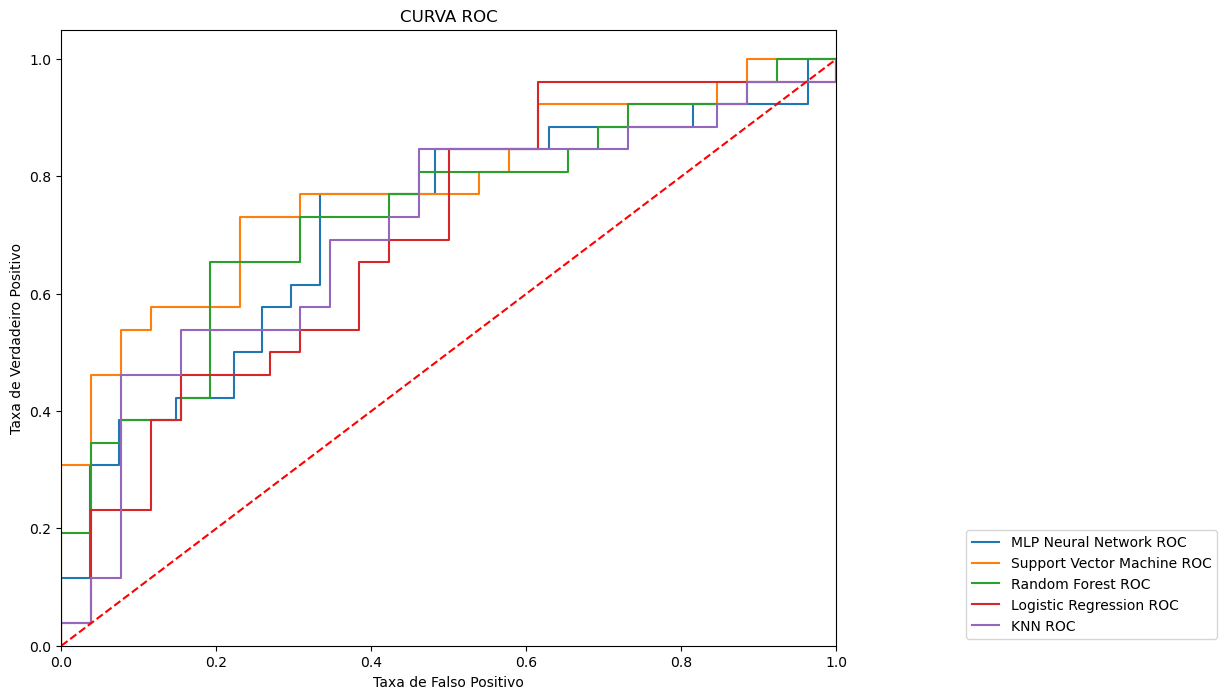

In [ ]:

last_run_basic = nested_cross_validation_grid_search(lista_modelos, dfx, dfy, 5, 5, rand_state=RANDOM_STATE)


## 3.3 - Treina Ensembles (não foi publicado)

In [19]:
from copy import deepcopy

from ensemble_train_util import select_best_models_of_type_fn, select_best_models_per_fold
from ensemble_train_util import train_ensemble

In [20]:
last_run_all = deepcopy(last_run_basic)

In [21]:
#models_list = ['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN']

for model_name in BASIC_MODEL_NAMES:
    print(f"\n\n\n **** TREINANDO ENSEMBLE PARA {model_name} ****\n")
    contracted_name = ''.join([name[0] for name in model_name.split()])
    results_ensemble = train_ensemble(select_best_models_of_type_fn(model_name), last_run_all, dfx, dfy, name_prefix=contracted_name)

    # merge results with results_with_ensemble
    last_run_all.update(results_ensemble)




 **** TREINANDO ENSEMBLE PARA MLP Neural Network ****

....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(





 **** TREINANDO ENSEMBLE PARA Support Vector Machine ****

..........


 **** TREINANDO ENSEMBLE PARA Random Forest ****

..........


 **** TREINANDO ENSEMBLE PARA Logistic Regression ****

..

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


..

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


..

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


..

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


..

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(





 **** TREINANDO ENSEMBLE PARA KNN ****

..........

In [22]:
results_ensemble = train_ensemble(select_best_models_per_fold, last_run_basic, dfx, dfy, name_prefix="BPF")  # BPF - best per fold

# check if keys have no intersection (no common key)
assert len(set(last_run_all.keys()) & set(results_ensemble.keys())) == 0

# merge results with results_with_ensemble
last_run_all.update(results_ensemble)

....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


....

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


.

c:\Users\pablo\.conda\envs\socialnet\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 3.4 - Salva Resultados

In [23]:
from util import save_results

In [24]:
last_run_all.keys()

dict_keys(['MLP Neural Network', 'Support Vector Machine', 'Random Forest', 'Logistic Regression', 'KNN', 'MNN-hard-vote', 'MNN-soft-vote', 'SVM-hard-vote', 'SVM-soft-vote', 'RF-hard-vote', 'RF-soft-vote', 'LR-hard-vote', 'LR-soft-vote', 'K-hard-vote', 'K-soft-vote', 'BPF-hard-vote', 'BPF-soft-vote'])

In [26]:
OUTPUT_FILE_PATH = f'resultados/resultados50p_{START_DATE_STR}_{SUB_DATASET}.npy'

save_results(OUTPUT_FILE_PATH, last_run_all, metadata)

print("Arquivo salvo:", OUTPUT_FILE_PATH)

Arquivo salvo: ./resultados/resultados50p_2024-08-15-13h01m_bolsonaro.npy


----

# FIM